In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # deep learning 

import os
import cv2
import matplotlib.pyplot as plt

## Skin Cancer Dataset
This dataset has been taken from Kaggle https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [3]:
df = pd.read_csv("../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
df.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp


shape of the dataset

In [4]:
df.shape

(10015, 7)

Mapping skin cancer

In [5]:
dx_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['dx'] = df['dx'].map(dx_dict.get)

## Handling Categorical data

In [6]:
from sklearn.preprocessing import LabelEncoder
dx_encoder = LabelEncoder()
df['diagnose'] = dx_encoder.fit_transform(df[['dx']].values.ravel())

In [7]:
df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [8]:
df['localization'].value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

In [9]:
df['dx'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: dx, dtype: int64

In [10]:
df['lesion_id'].value_counts()

HAM_0005263    6
HAM_0000835    6
HAM_0003789    6
HAM_0001863    6
HAM_0002364    5
              ..
HAM_0002485    1
HAM_0001827    1
HAM_0005390    1
HAM_0004683    1
HAM_0005863    1
Name: lesion_id, Length: 7470, dtype: int64

In [11]:
os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1')[:2]

['ISIC_0026858.jpg', 'ISIC_0026869.jpg']

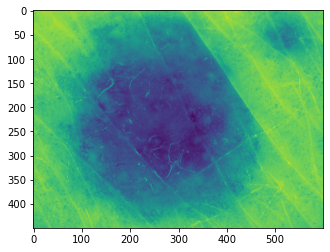

In [12]:
tmp = cv2.imread("../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025379.jpg",0)
plt.imshow(tmp)

In [13]:
images = []
labels = []
for dia, img in zip(df[["diagnose"]].values, df[["image_id"]].values):        
    loc = "../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/" + str(img[0]) + ".jpg"
    if os.path.exists(loc):
        cv2_img = cv2.imread(loc,0)
        cv2_img = cv2.resize(cv2_img, (100,100))
        images.append(cv2_img)
        labels.append(dia) 
    else:
        loc = "../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/" + str(img[0]) + ".jpg"
        cv2_img = cv2.imread(loc,0)
        cv2_img = cv2.resize(cv2_img, (100,100))
        images.append(cv2_img)
        labels.append(dia)
  
         
    

In [14]:
len(images), len(labels)

(10015, 10015)

In [15]:
np.array(images).shape

(10015, 100, 100)

In [16]:
images = np.array(images).reshape(10015, 100, 100,1)


In [17]:
labels = np.array(labels)
labels.shape

(10015, 1)

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
callback = myCallback()


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(images, labels, epochs=50, callbacks=[callback])
model.summary()

Epoch 1/50
313/313 [==============================] - 3s 10ms/step - loss: 1.5387 - accuracy: 0.6551
Epoch 2/50
313/313 [==============================] - 3s 8ms/step - loss: 1.0528 - accuracy: 0.6733
Epoch 3/50
313/313 [==============================] - 3s 8ms/step - loss: 1.0029 - accuracy: 0.6797
Epoch 4/50
313/313 [==============================] - 3s 8ms/step - loss: 0.9651 - accuracy: 0.6901
Epoch 5/50
313/313 [==============================] - 3s 8ms/step - loss: 0.9277 - accuracy: 0.6982
Epoch 6/50
313/313 [==============================] - 3s 8ms/step - loss: 0.8747 - accuracy: 0.7088
Epoch 7/50
313/313 [==============================] - 3s 8ms/step - loss: 0.8684 - accuracy: 0.7129
Epoch 8/50
313/313 [==============================] - 3s 8ms/step - loss: 0.8351 - accuracy: 0.7190
Epoch 9/50
313/313 [==============================] - 3s 8ms/step - loss: 0.7693 - accuracy: 0.7381
Epoch 10/50
313/313 [==============================] - 3s 8ms/step - loss: 0.7178 - accuracy: 0.752

In [19]:

print("After {} epochs our model reached accuracy of {:.2f}%".format(len(history.epoch), history.history['accuracy'][-1]*100))

After 32 epochs our model reached accuracy of 98.68%


In [21]:
# saving the model
model.save("skin_cancer_detection_7types.h5")